In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from math import log
#warnings.filterwarnings('ignore')

In [2]:
placement_train_data = pd.read_csv(filepath_or_buffer = 'Data/placement_train.csv')
placement_test_data = pd.read_csv(filepath_or_buffer = 'Data/placement_test.csv')
demographics_train_data = pd.read_csv(filepath_or_buffer='Data/demo_train.csv')
demographics_test_data = pd.read_csv(filepath_or_buffer='Data/demo_test.csv')

In [3]:
demographics_train_data.drop(['Ad set name','Date'], axis=1, inplace = True)
demographics_test_data.drop(['Ad set name','Date'], axis=1, inplace = True)

In [4]:
placement_train_data.drop(['Ad set name', 'Placement', 'Date'], axis=1, inplace = True)
placement_test_data.drop(['Ad set name', 'Placement', 'Date'], axis=1, inplace = True)

In [5]:
'''
Converting age from catagorical to numeric variable
'''
demographics_train_data['Age'] = demographics_train_data['Age'].map({'65+': '65-85','18-24':'18-24',
                 '25-34':'25-34','35-44':'35-44','45-54':'45-54','55-64':'55-64',
                 '13-17':'13-17'})

demographics_test_data['Age'] = demographics_test_data['Age'].map({'65+': '65-85','18-24':'18-24',
                 '25-34':'25-34','35-44':'35-44','45-54':'45-54','55-64':'55-64',
                 '13-17':'13-17'})

low = []
high = []
for i in demographics_train_data['Age']:
    low.append(int(i[0:2]))
    high.append(int(i[3:5]))
demographics_train_data['low_age'] = low
demographics_train_data['high_age'] = high
demographics_train_data.drop(['Age'], axis=1, inplace=True)

low = []
high = []
for i in demographics_test_data['Age']:
    low.append(int(i[0:2]))
    high.append(int(i[3:5]))
demographics_test_data['low_age'] = low
demographics_test_data['high_age'] = high
demographics_test_data.drop(['Age'], axis=1, inplace=True)

In [6]:
'''
One hot encoding
'''
def one_hot(data):
    for col_name in data.columns:
        if(data[col_name].dtype == 'object'):
            one_hot = pd.get_dummies(data[col_name])
            data.drop([col_name], axis = 1, inplace = True)
            data = data.join(one_hot)
    return data

placement_train_data = one_hot(placement_train_data)
demographics_train_data = one_hot(demographics_train_data)

demographics_test_data = one_hot(demographics_test_data)
placement_test_data = one_hot(placement_test_data)

In [7]:
'''
train, validation split
'''
demographics_val_data = demographics_train_data[int(len(demographics_train_data)*0.7):]
demographics_train_data = demographics_train_data[:int(len(demographics_train_data)*0.7)]

placement_val_data = placement_train_data[int(len(placement_train_data)*0.7):]
placement_train_data = placement_train_data[:int(len(placement_train_data)*0.7)]

In [8]:
'''
Splitting data into X,Y
'''
placement_train_Y = placement_train_data['Return on ad spend (ROAS)']
placement_train_X = placement_train_data.drop('Return on ad spend (ROAS)',axis=1)

demographics_train_Y = demographics_train_data['Return on ad spend (ROAS)']
demographics_train_X = demographics_train_data.drop('Return on ad spend (ROAS)',axis=1)

placement_val_Y = placement_val_data['Return on ad spend (ROAS)']
placement_val_X = placement_val_data.drop('Return on ad spend (ROAS)',axis=1)

demographics_val_Y = demographics_val_data['Return on ad spend (ROAS)']
demographics_val_X = demographics_val_data.drop('Return on ad spend (ROAS)',axis=1)

placement_test_Y = placement_test_data['Return on ad spend (ROAS)']
placement_test_X = placement_test_data.drop('Return on ad spend (ROAS)',axis=1)

demographics_test_Y = demographics_test_data['Return on ad spend (ROAS)']
demographics_test_X = demographics_test_data.drop('Return on ad spend (ROAS)',axis=1)

In [9]:
'''
Finds RMSE
'''
def RMSE(y_predicted,y):
    n = len(y_predicted)
    diff = [m - n for m,n in zip(y_predicted,y)]
    diff = [x**2 for x in diff]
    diff = sum(diff)
    diff = diff/n
    diff = diff**0.5
    return diff

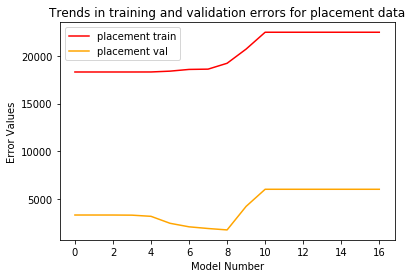

best placement lasso rmse: 1793.3270232613986
best demographics lasso rmse: 14042.197929758235


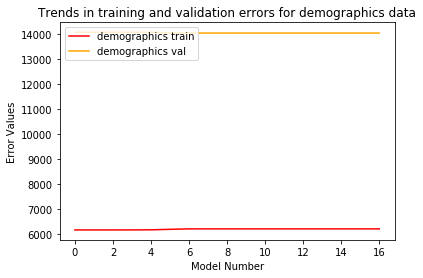

In [10]:
'''
Test lasso regression
'''
from sklearn.linear_model import Lasso

placement_train_rmse_list = []
placement_val_rmse_list = []
demographics_train_rmse_list = []
demographics_val_rmse_list = []

lambda_list = [0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000,10000000000,
               100000000000,1000000000000,10000000000000]

best_placement_lasso_model = None
best_placement_lasso_R_sq = -float('Inf')
best_placement_lasso_rmse = float('Inf')

best_demographics_lasso_model = None
best_demographics_lasso_R_sq = -float('Inf')
best_demographics_lasso_rmse = float('Inf')

for l in lambda_list:
    Lasso_Model = Lasso(alpha=l,max_iter = 10000000)
    
    Lasso_Model.fit(placement_train_X,placement_train_Y)
    current_placement_R_sq = Lasso_Model.score(placement_train_X,placement_train_Y)
    current_placement_train_rmse = RMSE(Lasso_Model.predict(placement_train_X),placement_train_Y)
    current_placement_val_rmse = RMSE(Lasso_Model.predict(placement_val_X),placement_val_Y)
    placement_train_rmse_list.append(current_placement_train_rmse)
    placement_val_rmse_list.append(current_placement_val_rmse)
    
    if current_placement_val_rmse < best_placement_lasso_rmse:
        best_placement_lasso_model = Lasso_Model
        best_placement_lasso_R_sq = current_placement_R_sq
        best_placement_lasso_rmse = current_placement_val_rmse
    
    Lasso_Model.fit(demographics_train_X,demographics_train_Y)
    current_demographics_R_sq = Lasso_Model.score(demographics_train_X,demographics_train_Y)
    current_demographics_train_rmse = RMSE(Lasso_Model.predict(demographics_train_X),demographics_train_Y)
    current_demographics_val_rmse = RMSE(Lasso_Model.predict(demographics_val_X),demographics_val_Y)
    demographics_train_rmse_list.append(current_demographics_train_rmse)
    demographics_val_rmse_list.append(current_demographics_val_rmse)
    
    if current_demographics_val_rmse < best_demographics_lasso_rmse:
        best_demographics_lasso_model = Lasso_Model
        best_demographics_lasso_R_sq = current_demographics_R_sq
        best_demographics_lasso_rmse = current_demographics_val_rmse
        
lambda_list = [log(x,10) for x in lambda_list]
plt.plot(list(range(0,len(placement_train_rmse_list))),placement_train_rmse_list,label = 'placement train',color = 'red')
plt.plot(list(range(0,len(placement_train_rmse_list))),placement_val_rmse_list,label = 'placement val', color = 'orange')
plt.xlabel('Model Number')
plt.ylabel('Error Values')
plt.title('Trends in training and validation errors for placement data')
plt.legend(loc='upper left')
plt.show()
print('best placement lasso rmse: ' + str(best_placement_lasso_rmse))
print('best demographics lasso rmse: ' + str(best_demographics_lasso_rmse))
plt.figure()
plt.plot(list(range(0,len(placement_train_rmse_list))),demographics_train_rmse_list,label = 'demographics train',color = 'red')
plt.plot(list(range(0,len(placement_train_rmse_list))),demographics_val_rmse_list,label = 'demographics val', color = 'orange')
plt.xlabel('Model Number')
plt.ylabel('Error Values')
plt.title('Trends in training and validation errors for demographics data')
plt.legend(loc='upper left')
plt.show()

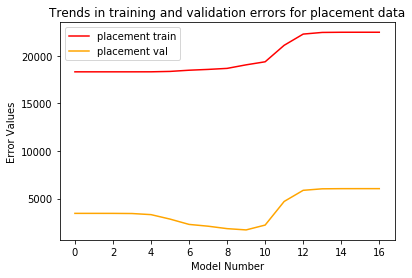

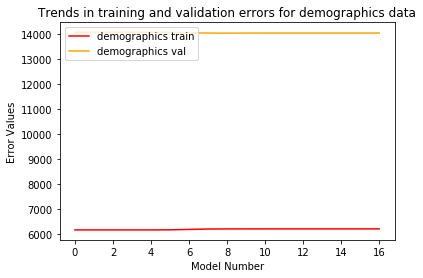

best placement ridge rmse: 1710.0814930417184
best demographics ridge rmse: 14039.375703833424


In [11]:
'''
Test ridge regression
'''
from sklearn.linear_model import Ridge

placement_train_rmse_list = []
placement_val_rmse_list = []
demographics_train_rmse_list = []
demographics_val_rmse_list = []

lambda_list = [0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000,10000000000,
               100000000000,1000000000000,10000000000000]

best_placement_ridge_model = None
best_placement_ridge_R_sq = -float('Inf')
best_placement_ridge_rmse = float('Inf')

best_demographics_ridge_model = None
best_demographics_ridge_R_sq = -float('Inf')
best_demographics_ridge_rmse = float('Inf')

for l in lambda_list:
    Ridge_Model = Ridge(alpha=l,max_iter = 10000000)
    
    Ridge_Model.fit(placement_train_X,placement_train_Y)
    current_placement_R_sq = Ridge_Model.score(placement_train_X,placement_train_Y)
    current_placement_train_rmse = RMSE(Ridge_Model.predict(placement_train_X),placement_train_Y)
    current_placement_val_rmse = RMSE(Ridge_Model.predict(placement_val_X),placement_val_Y)
    placement_train_rmse_list.append(current_placement_train_rmse)
    placement_val_rmse_list.append(current_placement_val_rmse)
    
    if current_placement_val_rmse < best_placement_ridge_rmse:
        best_placement_ridge_model = Ridge_Model
        best_placement_ridge_R_sq = current_placement_R_sq
        best_placement_ridge_rmse = current_placement_val_rmse
    
    Ridge_Model.fit(demographics_train_X,demographics_train_Y)
    current_demographics_R_sq = Ridge_Model.score(demographics_train_X,demographics_train_Y)
    current_demographics_train_rmse = RMSE(Ridge_Model.predict(demographics_train_X),demographics_train_Y)
    current_demographics_val_rmse = RMSE(Ridge_Model.predict(demographics_val_X),demographics_val_Y)
    demographics_train_rmse_list.append(current_demographics_train_rmse)
    demographics_val_rmse_list.append(current_demographics_val_rmse)
    
    if current_demographics_val_rmse < best_demographics_ridge_rmse:
        best_demographics_ridge_model = Ridge_Model
        best_demographics_ridge_R_sq = current_demographics_R_sq
        best_demographics_ridge_rmse = current_demographics_val_rmse
        
lambda_list = [log(x,10) for x in lambda_list]
plt.plot(list(range(0,len(placement_train_rmse_list))),placement_train_rmse_list,label = 'placement train',color = 'red')
plt.plot(list(range(0,len(placement_train_rmse_list))),placement_val_rmse_list,label = 'placement val', color = 'orange')
plt.xlabel('Model Number')
plt.ylabel('Error Values')
plt.title('Trends in training and validation errors for placement data')
plt.legend(loc='upper left')
plt.show()
plt.figure()
plt.plot(list(range(0,len(placement_train_rmse_list))),demographics_train_rmse_list,label = 'demographics train',color = 'red')
plt.plot(list(range(0,len(placement_train_rmse_list))),demographics_val_rmse_list,label = 'demographics val', color = 'orange')
plt.xlabel('Model Number')
plt.ylabel('Error Values')
plt.title('Trends in training and validation errors for demographics data')
plt.legend(loc='upper left')
plt.show()
print('best placement ridge rmse: ' + str(best_placement_ridge_rmse))
print('best demographics ridge rmse: ' + str(best_demographics_ridge_rmse))

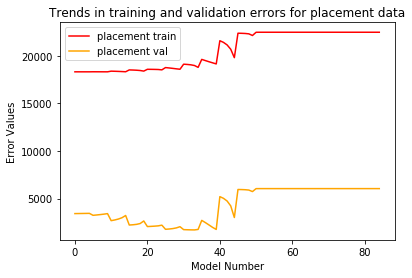

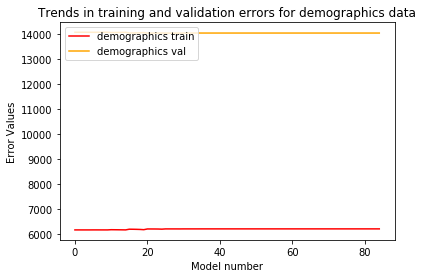

best placement Elastic Net rmse: 1705.1626444228714
best demographics Elastic Net rmse: 14039.649190174916


In [12]:
'''
Test elastic nets
'''
from sklearn.linear_model import ElasticNet

placement_train_rmse_list = []
placement_val_rmse_list = []
demographics_train_rmse_list = []
demographics_val_rmse_list = []

lambda_list = [0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000,10000000000,
               100000000000,1000000000000,10000000000000]
l1_ratio_list = [0.1,0.3,0.5,0.7,0.9]

best_placement_net_model = None
best_placement_net_R_sq = -float('Inf')
best_placement_net_rmse = float('Inf')

best_demographics_net_model = None
best_demographics_net_R_sq = -float('Inf')
best_demographics_net_rmse = float('Inf')

for l in lambda_list:
    for ratio in l1_ratio_list:
        Net_Model = ElasticNet(alpha=l,l1_ratio = ratio,max_iter = 10000000)

        Net_Model.fit(placement_train_X,placement_train_Y)
        current_placement_R_sq = Net_Model.score(placement_train_X,placement_train_Y)
        current_placement_train_rmse = RMSE(Net_Model.predict(placement_train_X),placement_train_Y)
        current_placement_val_rmse = RMSE(Net_Model.predict(placement_val_X),placement_val_Y)
        placement_train_rmse_list.append(current_placement_train_rmse)
        placement_val_rmse_list.append(current_placement_val_rmse)

        if current_placement_val_rmse < best_placement_net_rmse:
            best_placement_net_model = Net_Model
            best_placement_net_R_sq = current_placement_R_sq
            best_placement_net_rmse = current_placement_val_rmse

        Net_Model.fit(demographics_train_X,demographics_train_Y)
        current_demographics_R_sq = Net_Model.score(demographics_train_X,demographics_train_Y)
        current_demographics_train_rmse = RMSE(Net_Model.predict(demographics_train_X),demographics_train_Y)
        current_demographics_val_rmse = RMSE(Net_Model.predict(demographics_val_X),demographics_val_Y)
        demographics_train_rmse_list.append(current_demographics_train_rmse)
        demographics_val_rmse_list.append(current_demographics_val_rmse)

        if current_demographics_val_rmse < best_demographics_net_rmse:
            best_demographics_net_model = Net_Model
            best_demographics_net_R_sq = current_demographics_R_sq
            best_demographics_net_rmse = current_demographics_val_rmse
            
lambda_list = [log(x,10) for x in lambda_list]
plt.plot(list(range(0,len(placement_train_rmse_list))),placement_train_rmse_list,label = 'placement train',color = 'red')
plt.plot(list(range(0,len(placement_train_rmse_list))),placement_val_rmse_list,label = 'placement val', color = 'orange')
plt.xlabel('Model Number')
plt.ylabel('Error Values')
plt.title('Trends in training and validation errors for placement data')
plt.legend(loc='upper left')
plt.show()
plt.figure()
plt.plot(list(range(0,len(placement_train_rmse_list))),demographics_train_rmse_list,label = 'demographics train',color = 'red')
plt.plot(list(range(0,len(placement_train_rmse_list))),demographics_val_rmse_list,label = 'demographics val', color = 'orange')
plt.xlabel('Model number')
plt.ylabel('Error Values')
plt.title('Trends in training and validation errors for demographics data')
plt.legend(loc='upper left')
plt.show()
print('best placement Elastic Net rmse: ' + str(best_placement_net_rmse))
print('best demographics Elastic Net rmse: ' + str(best_demographics_net_rmse))

In [13]:
'''
Conclusion:

The best placement model is elastic net

The best demographics model is ridge
'''

print(best_placement_net_model)
print(best_demographics_ridge_model)

ElasticNet(alpha=1000, copy_X=True, fit_intercept=True, l1_ratio=0.7,
      max_iter=10000000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
Ridge(alpha=100000, copy_X=True, fit_intercept=True, max_iter=10000000,
   normalize=False, random_state=None, solver='auto', tol=0.001)


In [14]:
'''
Calculating test RMSE
'''
best_placement_net_model.fit(placement_train_X,placement_train_Y)
best_demographics_ridge_model.fit(demographics_train_X, demographics_train_Y)
print('Placement test RMSE: ' + str(RMSE(best_placement_net_model.predict(placement_test_X),placement_test_Y)))
print('Demographics test RMSE: ' + str(RMSE(best_demographics_ridge_model.predict(demographics_test_X),demographics_test_Y)))

Placement test RMSE: 11996.441687239236
Demographics test RMSE: 4064.939169311335
